<a href="https://colab.research.google.com/github/Rezowan-Ferdous/LRCN_Resnet/blob/main/PreTrained_LRCN_model_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=7c73959ac86e79ded166c4d0792556c6522ac6a1d447b3d08a54476596d5ca8d
  Stored in directory: /root/.cache/pip/wheel

In [ ]:
"""
VideoFrameGenerator - Simple Generator
--------------------------------------
A simple frame generator that takes distributed frames from
videos. It is useful for videos that are scaled from frame 0 to end
and that have no noise frames.
"""

import os
import glob
import numpy as np
import cv2 as cv
from math import floor
import logging
import re
log = logging.getLogger()

from keras.utils import Sequence
# from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import h5py
from keras.models import load_model
from keras.models import save_model


In [ ]:


def load_model_ext(filepath):
    model = load_model(filepath, custom_objects=None)
    f = h5py.File(filepath, mode='r')
    meta_data = None
    if 'my_meta_data' in f.attrs:
        meta_data = f.attrs.get('my_meta_data')
    f.close()
    return model, meta_data


def save_model_ext(model, filepath, overwrite=True, meta_data=None):
    save_model(model, filepath, overwrite)
    if meta_data is not None:
        f = h5py.File(filepath, mode='a')
        f.attrs['my_meta_data'] = meta_data
        f.close()


class VideoFrameGenerator(Sequence):
    """
    Create a generator that return batches of frames from video
    - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - use_header: bool, default to True to use video header to read the \
        frame count if possible

    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(
            self,
            rescale=1/255.,
            nb_frames: int = 5,
            classes: list = None,
            batch_size: int = 16,
            use_frame_cache: bool = False,
            target_shape: tuple = (224, 224),
            shuffle: bool = True,
            transformation: ImageDataGenerator = None,
            split_test: float = None,
            split_val: float = None,
            nb_channel: int = 3,
            glob_pattern: str = './videos/{classname}/*.avi',
            use_headers: bool = True,
            *args,
            **kwargs):

        # deprecation
        if 'split' in kwargs:
            log.warn("Warning, `split` argument is replaced by `split_val`, "
                     "please condider to change your source code."
                     "The `split` argument will be removed "
                     "in future releases.")
            split_val = float(kwargs.get('split'))

        self.glob_pattern = glob_pattern

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        if classes is None:
            classes = self._discover_classes()

        # we should have classes
        if len(classes) == 0:
            log.warn("You didn't provide classes list or "
                     "we were not able to discover them from "
                     "your pattern.\n"
                     "Please check if the path is OK, and if the glob "
                     "pattern is correct.\n"
                     "See https://docs.python.org/3/library/glob.html")

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split_val is not None:
            assert 0.0 < split_val < 1.0

        if split_test is not None:
            assert 0.0 < split_test < 1.0

        self.use_video_header = use_headers

        # then we don't need None anymore
        split_val = split_val if split_val is not None else 0.0
        split_test = split_test if split_test is not None else 0.0

        # be sure that classes are well ordered
        classes.sort()

        self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []
        self.test = []

        _validation_data = kwargs.get('_validation_data', None)
        _test_data = kwargs.get('_test_data', None)

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data

        elif _test_data is not None:
            # we only need to set files here
            self.files = _test_data

        else:
            if split_val > 0 or split_test > 0:
                for cls in classes:
                    files = glob.glob(glob_pattern.format(classname=cls))
                    nbval = 0
                    nbtest = 0
                    info = []

                    # generate validation and test indexes
                    indexes = np.arange(len(files))

                    if shuffle:
                        np.random.shuffle(indexes)

                    if 0.0 < split_val < 1.0:
                        nbval = int(split_val * len(files))
                        nbtrain = len(files) - nbval

                        # get some sample for validation_data
                        val = np.random.permutation(indexes)[:nbval]

                        # remove validation from train
                        indexes = np.array(
                            [i for i in indexes if i not in val])
                        self.validation += [files[i] for i in val]
                        info.append("validation count: %d" % nbval)

                    if 0.0 < split_test < 1.0:
                        nbtest = int(split_test * nbtrain)
                        nbtrain = len(files) - nbval - nbtest

                        # get some sample for test_data
                        val_test = np.random.permutation(indexes)[:nbtest]

                        # remove test from train
                        indexes = np.array(
                            [i for i in indexes if i not in val_test])
                        self.test += [files[i] for i in val_test]
                        info.append("test count: %d" % nbtest)

                    # and now, make the file list
                    self.files += [files[i] for i in indexes]
                    print("class %s, %s, train count: %d" %
                          (cls, ", ".join(info), nbtrain))

            else:
                for cls in classes:
                    self.files += glob.glob(glob_pattern.format(classname=cls))

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        if 'no_epoch_at_init' not in kwargs:
            self.on_epoch_end()

        kind = "train"
        if _validation_data is not None:
            kind = "validation"
        elif _test_data is not None:
            kind = "test"

        self._current = 0
        self._framecounters = {}
        print("Total data: %d classes for %d files for %s" % (
            self.classes_count,
            self.files_count,
            kind))

    def count_frames(self, cap, name, force_no_headers=False):
        """ Count number of frame for video
        if it's not possible with headers """
        if not force_no_headers and name in self._framecounters:
            return self._framecounters[name]

        total = cap.get(cv.CAP_PROP_FRAME_COUNT)

        if force_no_headers or total < 0:
            # headers not ok
            total = 0
            # TODO: we're unable to use CAP_PROP_POS_FRAME here
            # so we open a new capture to not change the
            # pointer position of "cap"
            c = cv.VideoCapture(name)
            while True:
                grabbed, frame = c.read()
                if not grabbed:
                    # rewind and stop
                    break
                total += 1

        # keep the result
        self._framecounters[name] = total

        return total

    def _discover_classes(self):
        pattern = os.path.realpath(self.glob_pattern)
        pattern = re.escape(pattern)
        pattern = pattern.replace('\\{classname\\}', '(.*?)')
        pattern = pattern.replace('\\*', '.*')

        files = glob.glob(self.glob_pattern.replace('{classname}', '*'))
        classes = set()
        for f in files:
            f = os.path.realpath(f)
            cl = re.findall(pattern, f)[0]
            classes.add(cl)

        return list(classes)

    def next(self):
        """ Return next element"""
        elem = self[self._current]
        self._current += 1
        if self._current == len(self):
            self._current = 0
            self.on_epoch_end()

        return elem

    def get_validation_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _validation_data=self.validation)

    def get_test_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _test_data=self.test)

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for _ in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        transformation = None

        for i in indexes:
            # prepare a transformation if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]

            video = self.files[i]
            classname = self._get_classname(video)

            # create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.

            if video not in self.__frame_cache:
                frames = self._get_frames(
                    video,
                    nbframe,
                    shape,
                    force_no_headers=not self.use_video_header)
                if frames is None:
                    # avoid failure, nevermind that video...
                    continue

                # add to cache
                self.__frame_cache[video] = frames

            else:
                frames = self.__frame_cache[video]

            # apply transformation
            if transformation is not None:
                frames = [self.transformation.apply_transform(
                    frame, transformation) for frame in frames]

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)

    def _get_classname(self, video: str) -> str:
        """ Find classname from video filename following the pattern """

        # work with real path
        video = os.path.realpath(video)
        pattern = os.path.realpath(self.glob_pattern)

        # remove special regexp chars
        pattern = re.escape(pattern)

        # get back "*" to make it ".*" in regexp
        pattern = pattern.replace('\\*', '.*')

        # use {classname} as a capture
        pattern = pattern.replace('\\{classname\\}', '(.*?)')

        # and find all occurence
        classname = re.findall(pattern, video)[0]
        return classname

    def _get_frames(self, video, nbframe, shape, force_no_headers=False):
        cap = cv.VideoCapture(video)
        total_frames = self.count_frames(cap, video, force_no_headers)
        orig_total = total_frames
        if total_frames % 2 != 0:
            total_frames += 1
        frame_step = floor(total_frames/(nbframe-1))
        # TODO: fix that, a tiny video can have a frame_step that is
        # under 1
        frame_step = max(1, frame_step)
        frames = []
        frame_i = 0

        while True:
            grabbed, frame = cap.read()
            if not grabbed:
                break

            frame_i += 1
            if frame_i == 1 or frame_i % frame_step == 0 or frame_i == orig_total:
                # resize
                frame = cv.resize(frame, shape)

                # use RGB or Grayscale ?
                if self.nb_channel == 3:
                    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                else:
                    frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

                # to np
                frame = tf.keras.utils.img_to_array(frame) * self.rescale

                # keep frame
                frames.append(frame)

            if len(frames) == nbframe:
                break

        cap.release()

        if not force_no_headers and len(frames) != nbframe:
            # There is a problem here
            # That means that frame count in header is wrong or broken,
            # so we need to force the full read of video to get the right
            # frame counter
            return self._get_frames(
                    video,
                    nbframe,
                    shape,
                    force_no_headers=True)

        if force_no_headers and len(frames) != nbframe:
            # and if we really couldn't find the real frame counter
            # so we return None. Sorry, nothing can be done...
            log.error("\33[1;37;41m Frame count is not OK for video %s, "
                      "%d total, %d extracted \33[0m" % (
                        video, total_frames, len(frames)))
            return None
        return np.array(frames)

In [ ]:
from keras import layers,applications
from keras.models import Sequential


def convlstm_model(SEQUENCE_LENGTH, IMAGE_SIZE, CLASSES_LIST):
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(layers.ConvLSTM2D(filters=8, kernel_size=(7, 7), activation='tanh', data_format="channels_last",
                                recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                           IMAGE_SIZE, IMAGE_SIZE, 3)))

    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))

    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(5, 5), activation='tanh', data_format="channels_last",
                                recurrent_dropout=0.2, return_sequences=True))

    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))

    model.add(layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                                recurrent_dropout=0.2, return_sequences=True))

    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))

    model.add(layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                                recurrent_dropout=0.2, return_sequences=True))

    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2),
              padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(len(CLASSES_LIST), activation="softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def LRCN_model(SEQUENCE_LENGTH, IMAGE_SIZE, CLASSES_LIST):
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
    lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation=lrelu),
                                     input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE, IMAGE_SIZE, 3)))

    model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Conv2D(
        32, (3, 3), padding='same', activation=lrelu)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Conv2D(
        64, (3, 3), padding='same', activation=lrelu)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Conv2D(
        64, (3, 3), padding='same', activation=lrelu)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Flatten()))

    # model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(256))

    # model.add(layers.Bidirectional(layers.LSTM(64, activation='tanh'), name='bilstm'))   #(model)#双向LSTM层
    # model.add(layers.Bidirectional(layers.LSTM(128, activation='tanh'), name='bilstm2'))   #(model)#双向LSTM层
    # model.add(layers.MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3),value_dim=2,value=7))
    # attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
    # model=Multiply()([model, attention])#attention与LSTM对应数值相乘



    model.add(layers.Dense(256))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model


def LRCN_Resnet(SEQUENCE_LENGTH, IMAGE_SIZE, CLASSES_LIST):

    res_model=applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    )
    for layer in res_model.layers[:143]:
      layer.trainable= False
    model = Sequential()
    model.add(layers.TimeDistributed(res_model, input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE, IMAGE_SIZE, 3)))  # Example input shape: (sequence_length, height, width, channels)

    # model.add(layers.TimeDistributed(res_model, input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE, IMAGE_SIZE, 3)))  # Example input shape: (sequence_length, height, width, channels)

    # # Define the Model Architecture.
    # ########################################################################################################################
    # model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu')))
    #                                   # input_shape=(SEQUENCE_LENGTH, IMAGE_SIZE, IMAGE_SIZE, 3))

    # model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4))))
    # model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    # model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu')))
    # model.add(layers.TimeDistributed(layers.MaxPooling2D((4, 4))))
#     model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation=lrelu)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    # model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation=lrelu)))
#     model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
#     model.add(layers.TimeDistributed(layers.Dropout(0.25)))

    model.add(layers.TimeDistributed(layers.Flatten()))

    # model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(256))

#     model.add(layers.Dropout(0.25))

    model.add(layers.Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model


In [ ]:
import random
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
import argparse
import time
import mlflow
import json

from keras.callbacks import EarlyStopping, ModelCheckpoint
# from models import convlstm_model, LRCN_model
from keras.preprocessing.image import ImageDataGenerator
# import VideoFrameGenerator, save_model_ext


seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


DATASET_DIR ='/content/drive/MyDrive/PHD/ActionPrediction/Dataset/UCF50'
SEQUENCE_LENGTH = 16
IMAGE_SIZE = 224
model_type = 'LRCN'
epochs = 50
batch_size = 16

# some global params
SIZE = (IMAGE_SIZE, IMAGE_SIZE)
CHANNELS = 3
n = 0

# pattern to get videos and classes
glob_pattern= DATASET_DIR + '/{classname}/*'

# Data Extraction Start
s_time = time.time()

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = sorted(os.listdir(DATASET_DIR))
labels_string = json.dumps(CLASSES_LIST + [SEQUENCE_LENGTH, IMAGE_SIZE])



In [ ]:
# for data augmentation
preprocessor = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create video frame generator
train_gen = VideoFrameGenerator(
    classes=CLASSES_LIST,
    glob_pattern=glob_pattern,
    nb_frames=SEQUENCE_LENGTH,
#     split=.1,
    split_val=.1,
    split_test=.05,
    shuffle=True,
    batch_size=batch_size,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=preprocessor,
    use_frame_cache=False
)

class BaseballPitch, validation count: 15, test count: 6, train count: 129
class Basketball, validation count: 13, test count: 6, train count: 118
class BenchPress, validation count: 16, test count: 7, train count: 137
class Biking, validation count: 14, test count: 6, train count: 128
class Billiards, validation count: 15, test count: 6, train count: 129
class BreastStroke, validation count: 10, test count: 4, train count: 87
class CleanAndJerk, validation count: 11, test count: 5, train count: 96
class Diving, validation count: 16, test count: 7, train count: 140
class Drumming, validation count: 16, test count: 7, train count: 138
class Fencing, validation count: 11, test count: 5, train count: 95
class GolfSwing, validation count: 14, test count: 6, train count: 122
class HighJump, validation count: 12, test count: 5, train count: 106
class HorseRace, validation count: 12, test count: 5, train count: 110
class HorseRiding, validation count: 19, test count: 8, train count: 170
class

In [ ]:
# # Validation Generator
# valid_gen = train_gen.get_validation_generator()

# # Data Size
# train_size = int(train_gen.files_count)
# val_size = int(valid_gen.files_count)
# total_data = train_size + val_size

# Validation Generator
valid_gen = train_gen.get_validation_generator()


# Validation Generator
test_gen = train_gen.get_test_generator()

# Data Size
train_size = int(train_gen.files_count)
val_size = int(valid_gen.files_count)
test_size = int(test_gen.files_count)
total_data = train_size + val_size + test_size



Total data: 50 classes for 656 files for validation
Total data: 50 classes for 280 files for test


In [ ]:
if model_type == 'LRCN':
    print("\33[5;30;43m [INFO] Selected LRCN Model \33[0m")
#     model = LRCN_model(SEQUENCE_LENGTH, IMAGE_SIZE, CLASSES_LIST)
    model = LRCN_Resnet(SEQUENCE_LENGTH, IMAGE_SIZE, CLASSES_LIST)
    print("\33[1;37;42m [INFO] LRCN Created Successfully \33[0m")
else:
    print('\33[91m [INFO] Model NOT Choosen!! \33[0m')

# Model Dir
while True:
    path_to_model_dir = f'runs/train/{model_type}{n}'
    if not os.path.isdir(path_to_model_dir):
        os.makedirs(path_to_model_dir, exist_ok=True)
        print(f'\33[92m [INFO] Created {path_to_model_dir} Folder \33[0m')
        break
    else:
        n += 1

png_name = f'{model_type}_model_str.png'
path_to_model_str = os.path.join(path_to_model_dir, png_name)
# Plot the structure of the contructed model.
tf.keras.utils.plot_model(model, to_file=path_to_model_str,
           show_shapes=True, show_layer_names=True)
print(f'\33[92m [INFO] Successfully Created {png_name} \33[0m')


 [INFO] Selected LRCN Model 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 16, 7, 7, 2048)   23564800  
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 7, 7, 64)     1179712   
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 3, 3, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 64)     36928     
 tributed)                                                       
                                                                 
 time_distributed_9 (Time

In [ ]:

from tensorflow.keras import metrics


# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Model Checkpoint
ckpt_path = os.path.join(path_to_model_dir, "weight-{epoch:02d}-{val_accuracy:.2f}.h5")
checkpoint = ModelCheckpoint(
    ckpt_path, monitor='val_accuracy',
    verbose=1, save_best_only=False, mode='max'
)

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=["accuracy",metrics.AUC(), metrics.Precision(), metrics.Recall()])

print(f'\33[1;37;44m [INFO] {model_type} Model Training Started... \33[0m')



 [INFO] LRCN Model Training Started... 


In [ ]:
# MLFlow
mlflow.set_experiment('Action Recognition')
with mlflow.start_run(run_name=f'{model_type}_model'):
    mlflow.tensorflow.autolog()
    # Start training the model.
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping_callback, checkpoint]
    )

    print(f'\33[1;37;42m [INFO] Successfully Completed {model_type} Model Training \33[0m')

    # Training End
    te_time = time.time()
    t2 = (te_time-s_time)/60
    print(f'\33[5;30;46m [INFO] Model Training Completed in {round(t2, 2)} Minutes \33[0m')

    # Evaluate the trained model.
    model_evaluation_history = model.evaluate(valid_gen)

    # Get the loss and accuracy from model_evaluation_history.
    model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

    # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
    model_file_name = f'{model_type}_model_loss_{model_evaluation_loss:.3}_acc_{model_evaluation_accuracy:.3}.h5'

    # Save your Model
    path_to_save_model = os.path.join(path_to_model_dir, model_file_name)
    # model.save(path_to_save_model)
    # Saved model with class names
    save_model_ext(model, path_to_save_model, meta_data=labels_string)
    print(f'\33[1;37;42m [INFO] Model {model_file_name} saved Successfully.. \33[0m')

    # Model Size
    mb_size = os.path.getsize(f'{path_to_save_model}')
    mb_size = round(mb_size / 1e+6, 2)
    print(f'\33[5;30;47m [INFO] {model_type} Model Size: {mb_size} MB \33[0m')

    # Plot History
    metric_loss = history.history['loss']
    metric_val_loss = history.history['val_loss']
    metric_accuracy = history.history['accuracy']
    metric_val_accuracy = history.history['val_accuracy']

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_loss))

    # Plot the Graph.
    plt.plot(epochs, metric_loss, 'blue', label=metric_loss)
    plt.plot(epochs, metric_val_loss, 'red', label=metric_val_loss)
    plt.plot(epochs, metric_accuracy, 'magenta', label=metric_accuracy)
    plt.plot(epochs, metric_val_accuracy, 'green', label=metric_val_accuracy)

    # Add title to the plot.
    plt.title(str('Model Metrics'))

    # Add legend to the plot.
    plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])

    # If the plot already exist, remove
    metrics_png_name = f'{model_type}_metrics.png'
    path_to_metrics = os.path.join(path_to_model_dir, metrics_png_name)
    plt.savefig(path_to_metrics, bbox_inches='tight')
    print(f'\33[1;37;42m [INFO] Successfully Saved {metrics_png_name} \33[0m')

    # MLFlow Metrics
    mlflow.log_metric('Input Image Size', IMAGE_SIZE)
    mlflow.log_metric('Total Image Data', total_data)
    mlflow.log_metric('Train Size', train_size)
    mlflow.log_metric('Validation Size', val_size)
    mlflow.log_artifact(f'{path_to_metrics}')
    mlflow.log_metric('Model Size MB', mb_size)

    print("\33[1;30;43m [INFO] MLFlow Run: \33[0m", mlflow.active_run().info.run_uuid)
mlflow.end_run()

# Total Time
e_time = time.time()
t3 = (e_time-s_time)/60
print(f'\33[5;30;46m [INFO] Completed All process in {round(t3, 2)} Minutes \33[0m')

2023/06/05 15:02:44 INFO mlflow.tracking.fluent: Experiment with name 'Action Recognition' does not exist. Creating a new experiment.


Epoch 1/5
313/362 [========================>.....] - ETA: 13:15 - loss: 3.4626 - accuracy: 0.1004 - auc: 0.7485 - precision: 0.8429 - recall: 0.0118

In [ ]:
# Load LRCN_model 'runs/train/LRCN4/LRCN_model_loss_0.529_acc_0.859.h5'
# saved_model = load_model('runs/train/LRCN4/LRCN_model_loss_0.529_acc_0.859.h5')


In [ ]:
model_evaluation_history_test = model.evaluate(test_gen)


2023-06-04 20:38:50.919787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 9s 496ms/step - loss: 3.6860 - accuracy: 0.1066 - categorical_accuracy: 0.1066 - auc: 0.7063 - precision: 0.3750 - recall: 0.0110


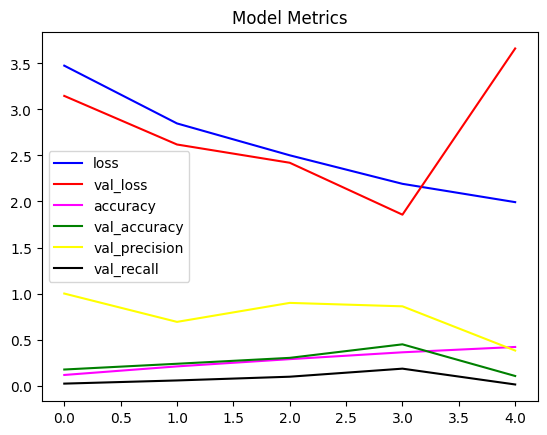

In [ ]:
# Plot History
metric_loss = history.history['loss']
metric_val_loss = history.history['val_loss']
metric_accuracy = history.history['accuracy']
metric_val_accuracy = history.history['val_accuracy']
metric_val_auc = history.history['val_auc']
metric_val_precision = history.history['val_precision']
metric_val_recall = history.history['val_recall']
#     metric_val_accuracy = history.history['val_accuracy']

# Construct a range object which will be used as x-axis (horizontal plane) of the graph.
epochs = range(len(metric_loss))

# Plot the Graph.
plt.plot(epochs, metric_loss, 'blue', label=metric_loss)
plt.plot(epochs, metric_val_loss, 'red', label=metric_val_loss)
plt.plot(epochs, metric_accuracy, 'magenta', label=metric_accuracy)
plt.plot(epochs, metric_val_accuracy, 'green', label=metric_val_accuracy)
plt.plot(epochs, metric_val_auc, 'purple', label=metric_val_auc)
plt.plot(epochs, metric_val_precision, 'yellow', label=metric_val_precision)
plt.plot(epochs, metric_val_recall, 'orange', label=metric_val_recall)

# Add title to the plot.
plt.title(str('Model Metrics'))

# Add legend to the plot.
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy','auc','precision','recall'])


In [ ]:
history.history

{'loss': [3.4749605655670166,
  2.8475208282470703,
  2.5013537406921387,
  2.1916003227233887,
  1.992705225944519],
 'accuracy': [0.11577297747135162,
  0.208913654088974,
  0.2876044511795044,
  0.3619428873062134,
  0.41991642117500305],
 'categorical_accuracy': [0.11577297747135162,
  0.208913654088974,
  0.2876044511795044,
  0.3619428873062134,
  0.41991642117500305],
 'auc': [0.7326667308807373,
  0.8700029850006104,
  0.9051236510276794,
  0.9308678507804871,
  0.9435895681381226],
 'precision': [0.8391608595848083,
  0.7708333134651184,
  0.7343485355377197,
  0.7581632733345032,
  0.7541818022727966],
 'recall': [0.02089136466383934,
  0.038649026304483414,
  0.07555710524320602,
  0.1293523609638214,
  0.1805362105369568],
 'val_loss': [3.146389961242676,
  2.6186861991882324,
  2.4205007553100586,
  1.8565658330917358,
  3.661503314971924],
 'val_accuracy': [0.17499999701976776,
  0.23749999701976776,
  0.30156248807907104,
  0.44843751192092896,
  0.10468749701976776],
 '

In [ ]:
model_evaluation_loss, model_evaluation_accuracy,auc, test_auc, test_precision, test_recall= model_evaluation_history

In [ ]:
# model_evaluation_loss, model_evaluation_accuracy , test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)

print("Test Loss:", model_evaluation_loss)
print("Test Accuracy:", model_evaluation_accuracy)
print("Test AUC:", test_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 3.6497700214385986
Test Accuracy: 0.10625000298023224
Test AUC: 0.7115322351455688
Test Precision: 0.4000000059604645
Test Recall: 0.012500000186264515


In [ ]:
print(history.history)
import pandas as pd
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Save the history DataFrame to a CSV file
history_df.to_csv(path_to_model_dir+'history.csv', index=True)

# os.path.join(path_to_model_dir, model_file_name)

{'loss': [3.4749605655670166, 2.8475208282470703, 2.5013537406921387, 2.1916003227233887, 1.992705225944519], 'accuracy': [0.11577297747135162, 0.208913654088974, 0.2876044511795044, 0.3619428873062134, 0.41991642117500305], 'categorical_accuracy': [0.11577297747135162, 0.208913654088974, 0.2876044511795044, 0.3619428873062134, 0.41991642117500305], 'auc': [0.7326667308807373, 0.8700029850006104, 0.9051236510276794, 0.9308678507804871, 0.9435895681381226], 'precision': [0.8391608595848083, 0.7708333134651184, 0.7343485355377197, 0.7581632733345032, 0.7541818022727966], 'recall': [0.02089136466383934, 0.038649026304483414, 0.07555710524320602, 0.1293523609638214, 0.1805362105369568], 'val_loss': [3.146389961242676, 2.6186861991882324, 2.4205007553100586, 1.8565658330917358, 3.661503314971924], 'val_accuracy': [0.17499999701976776, 0.23749999701976776, 0.30156248807907104, 0.44843751192092896, 0.10468749701976776], 'val_categorical_accuracy': [0.17499999701976776, 0.23749999701976776, 0.

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

In [ ]:
ls 'runs/train/LRCN4/LRCN_model_loss_0.529_acc_0.859.h5'

LRCN_metrics.png                    weight-17-0.75.h5  weight-35-0.82.h5
LRCN_model_loss_0.529_acc_0.859.h5  weight-18-0.78.h5  weight-36-0.87.h5
weight-01-0.11.h5                   weight-19-0.78.h5  weight-37-0.84.h5
weight-02-0.32.h5                   weight-20-0.79.h5  weight-38-0.85.h5
weight-03-0.33.h5                   weight-21-0.75.h5  weight-39-0.87.h5
weight-04-0.46.h5                   weight-22-0.76.h5  weight-40-0.80.h5
weight-05-0.45.h5                   weight-23-0.65.h5  weight-41-0.80.h5
weight-06-0.08.h5                   weight-24-0.84.h5  weight-42-0.87.h5
weight-07-0.57.h5                   weight-25-0.82.h5  weight-43-0.86.h5
weight-08-0.61.h5                   weight-26-0.84.h5  weight-44-0.90.h5
weight-09-0.66.h5                   weight-27-0.85.h5  weight-45-0.88.h5
weight-10-0.69.h5                   weight-28-0.82.h5  weight-46-0.86.h5
weight-11-0.69.h5                   weight-29-0.84.h5  weight-47-0.85.h5
weight-12-0.62.h5                   weight-30-0.84.

In [ ]:
 saved_model = load_model('runs/train/LRCN4/LRCN_model_loss_0.529_acc_0.859.h5')